# Working in more than one dimension
Although in general the case of having a fit to 1D data is the most frequent, sometimes it is needed to perform fits in many dimensions. This is completely supported by MinKit, for both the unbinned and binned cases, although with some limitations. These limitations are imposed by the multidimensional nature of the problem, since calculating numerical integrals might lead to enormous arrays for the grids to use. As always, we start with a few imports, and we will define two functions to help us to plot the results.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import minkit
import numpy as np

minkit.initialize()

def create_figure():

    fig = plt.figure(figsize=(10, 10))

    left, width = 0.12, 0.55
    bottom, height = 0.12, 0.55
    bottom_h = left_h = left + width + 0.02

    ax0 = plt.axes([left, bottom, width, height])
    ax1 = plt.axes([left, bottom_h, width, 0.25], sharex=ax0)
    ax2 = plt.axes([left_h, bottom, 0.25, height], sharey=ax0)

    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_yticklabels(), visible=False)
    
    return fig, ax0, ax1, ax2


def pdf_plot_values( pdf, xp, yp, values, xedges, yedges ):

    grid = minkit.evaluation_grid([x, y], np.array([x.bounds, y.bounds]).flatten(), 1000)

    gx = minkit.as_ndarray(grid['x'])
    gy = minkit.as_ndarray(grid['y'])

    gxe = minkit.evaluation_grid([x], x.bounds, 1001)['x']
    gye = minkit.evaluation_grid([y], y.bounds, 1001)['y']

    pdf_values = minkit.scale_pdf_values(pdf, grid, values, [xedges, yedges])

    igx = np.digitize(gx, gxe) - 1
    igy = np.digitize(gy, gye) - 1

    igx[igx == len(gxe) - 1] = len(gxe) - 2
    igy[igy == len(gye) - 1] = len(gxe) - 2

    rx = (len(xedges) - 1) / 1001 # ratio of bin areas in X
    ry = (len(yedges) - 1) / 1001 # ratio of bin areas in Y

    xpdf = np.bincount(igx, ry * pdf_values, minlength=len(gxe) - 1)
    ypdf = np.bincount(igy, rx * pdf_values, minlength=len(gye) - 1)

    # Now we can plot it
    gxc = (gxe[1:] + gxe[:-1]) / 2.
    gyc = (gye[1:] + gye[:-1]) / 2.
    
    return gxc, xpdf, gyc, ypdf

## Unbinned case
Let's create an unbinned data set in two dimensions from two different Gaussian distributions with shared mean and standard deviation, do a fit to it, and plot the results.

------------------------------------------------------------------
| FCN = 5.671E+05               |      Ncalls=33 (33 total)      |
| EDM = 1.31E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------

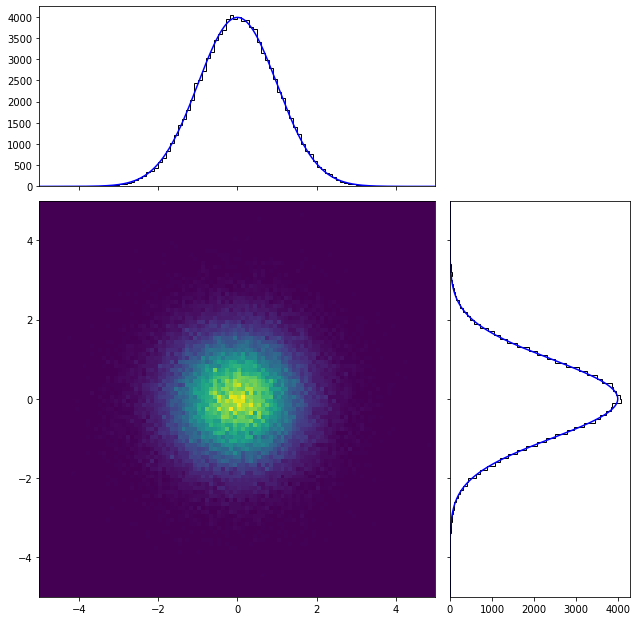

In [2]:
# Define the model
x = minkit.Parameter('x', bounds=(-5, +5))
y = minkit.Parameter('y', bounds=(-5, +5))
c = minkit.Parameter('c', 0, bounds=(-5, +5))
s = minkit.Parameter('s', 1, bounds=(0.1, 3))

gx = minkit.Gaussian('gx', x, c, s)
gy = minkit.Gaussian('gy', y, c, s)

pdf = minkit.ProdPDFs('pdf', [gx, gy])

# Generate data and fit it
data = pdf.generate(100000)

with minkit.minimizer('uml', pdf, data) as minimizer:
    result = minimizer.migrad()

print(result)

pdf.set_values(**minkit.minuit_to_registry(result.params).values())

# Plot the results
xv = minkit.as_ndarray(data['x'])
yv = minkit.as_ndarray(data['y'])

fig, ax0, ax1, ax2 = create_figure()

# Plot the data
values, xedges, yedges, _ = ax0.hist2d(xv, yv, bins=100, range=[x.bounds, y.bounds]);

# Calculate the projections of the data and plot them
xproj = np.sum(values, axis=0)
yproj = np.sum(values, axis=1)

xc = (xedges[1:] + xedges[:-1]) / 2.
yc = (yedges[1:] + yedges[:-1]) / 2.

ax1.hist(xc, bins=xedges, weights=xproj, histtype='step', color='k');
ax2.hist(yc, bins=yedges, weights=yproj, histtype='step', orientation='horizontal', color='k');

# Calculate the values of the PDF and plot them
gxc, xpdf, gyc, ypdf = pdf_plot_values(pdf, x, y, values, xedges, yedges)
ax1.plot(gxc, xpdf, color='b');
ax2.plot(ypdf, gyc, color='b');

The amount of code needed to generate and fit is very similar to that of the 1D case. In order to plot the results, it is needed to work a bit more if one wants to get the projections of the PDF in each dimension, since it comes necessary to sum the contribution in the other. By using "numpy.histogramdd" one can extend the previous code to the n-dimensional case, although computation might turn slower due to the curse of dimensionality.

## Binned case
Similarly to what has been done in the previous section, one can do the same thing on binned data sets.

------------------------------------------------------------------
| FCN = -8.144E+05              |      Ncalls=73 (73 total)      |
| EDM = 1.09E-07 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------

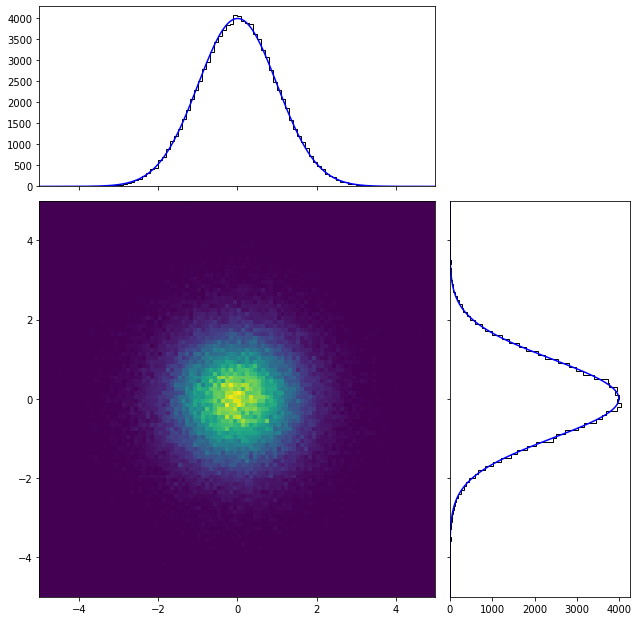

In [6]:
# Transform data to binned, and do a fit to it
binned_data = data.make_binned(bins=100)

xedges, yedges = minkit.as_ndarray(binned_data['x']), minkit.as_ndarray(binned_data['y'])

values = minkit.as_ndarray(binned_data.values)

pdf.evaluate_binned(binned_data)

with minkit.minimizer('bml', pdf, binned_data) as minimizer:
    result = minimizer.migrad()

print(result)

pdf.set_values(**minkit.minuit_to_registry(result.params).values())

# Plot the results
fig, ax0, ax1, ax2 = create_figure()

data_values = minkit.as_ndarray(binned_data.values)

xedges, yedges = minkit.as_ndarray(binned_data['x']), minkit.as_ndarray(binned_data['y'])

xc = (xedges[1:] + xedges[:-1]) / 2.
yc = (yedges[1:] + yedges[:-1]) / 2.

xv, yv = tuple(a.flatten() for a in np.meshgrid(xc, yc))

values, _, _, _ = ax0.hist2d(xv, yv, bins=(xedges, yedges), weights=data_values);

# Calculate the projections of the data and plot them
xproj = np.sum(values, axis=0)
yproj = np.sum(values, axis=1)

xc = (xedges[1:] + xedges[:-1]) / 2.
yc = (yedges[1:] + yedges[:-1]) / 2.

ax1.hist(xc, bins=xedges, weights=xproj, histtype='step', color='k');
ax2.hist(yc, bins=yedges, weights=yproj, histtype='step', orientation='horizontal', color='k');

# Calculate the values of the PDF and plot them
gxc, xpdf, gyc, ypdf = pdf_plot_values(pdf, x, y, values, xedges, yedges)
ax1.plot(gxc, xpdf, color='b');
ax2.plot(ypdf, gyc, color='b');

As it can be clearly seen, the result is similar to that of the unbinned case.